In [1]:
%matplotlib inline
import numpy as np
from scipy import ndimage
import math
import cv2
import random
import sys
import math
import requests
import matplotlib.pyplot as plt
np.set_printoptions(threshold=sys.maxsize)

## Useful functions that may help you

In [2]:
def im2double(im):
    info = np.iinfo(im.dtype) # Get the data type of the input image
    return im.astype(np.float) / info.max # Divide all values by the largest possible value in the datatype

### Functions that might be helpful ###

def im2col_sliding(A, BSZ, stepsize=1):
    # This function is similar to the `im2col` function from MATLAB. It rearrange image blocks into columns.
    # 
    # Paste the following command to a coding block and check out the results to get more intuitions!
    # r = np.arange(25).reshape(5, 5); s = (3, 3); print(im2col_sliding(r, s).shape); print(im2col_sliding(r, s))

    # Parameters
    m,n = A.shape
    s0, s1 = A.strides
    nrows = m-BSZ[0]+1
    ncols = n-BSZ[1]+1
    shp = BSZ[0],BSZ[1],nrows,ncols
    strd = s0,s1,s0,s1
    out_view = np.lib.stride_tricks.as_strided(A, shape=shp, strides=strd)
    return out_view.reshape(BSZ[0]*BSZ[1],-1)[:,::stepsize]

def sub2ind(array_shape, rows, cols):
    return rows*array_shape[1] + cols    

In [3]:
r = np.arange(25).reshape(5, 5); s = (3, 3); print(im2col_sliding(r, s).shape); print(im2col_sliding(r, s))

(9, 9)
[[ 0  1  2  5  6  7 10 11 12]
 [ 1  2  3  6  7  8 11 12 13]
 [ 2  3  4  7  8  9 12 13 14]
 [ 5  6  7 10 11 12 15 16 17]
 [ 6  7  8 11 12 13 16 17 18]
 [ 7  8  9 12 13 14 17 18 19]
 [10 11 12 15 16 17 20 21 22]
 [11 12 13 16 17 18 21 22 23]
 [12 13 14 17 18 19 22 23 24]]


In [4]:
r

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

## Get the images

In [5]:
r = requests.get("http://6.869.csail.mit.edu/sp22/pset7/rings.jpg", timeout=0.5)
if r.status_code == 200:
    with open("rings.jpg", 'wb') as f:
        f.write(r.content)
r = requests.get("http://6.869.csail.mit.edu/sp22/pset7/texture.jpg", timeout=0.5)
if r.status_code == 200:
    with open("texture.jpg", 'wb') as f:
        f.write(r.content)

## "Find_matches" function

In [6]:
def Find_matches(template, sample, G):


    ### Note: below is just a provided sketch, you can have your own code flow 
    ### parameters, as used by Efros and Leung
    epsilon = 0.1
    delta = 0.3
    
    #### TODO:
    # 1. construct validMask is a square mask of width w that is 1 where template is filled
    # 2. multiply validMask by G. Make sure the result is normalized to sum to 1. 
    # 3. unfold the result to a column vector (you can use x.ravel(order='F') for column-major order)
    _, w, nChannels = template.shape
    validMask = ~np.isnan(template)
    # multiply by G
    msk = validMask * G
    # normalize
    msk = msk/msk.sum()
    # unfold to column vector
    msk = msk.ravel(order = 'F')

    #### TODO:
    # Play with im2col_sliding()! 
    # partition sample to blocks (represented by column vectors). 
    # We can actually do this only once, and pass this representation to this 
    # function, but we leave it as is in order not to change function signature 
    # that was instructed.
    # 1. create a 2D feature matrix of size [template.size, nBlocks] containing 
    # the unfolded sample patches (you will need to concatenate channels for an RGB image)
    # 2. unfold the template to a column vector (you can use x.ravel(order='F') for column-major order)
    feature_matrix = np.concatenate(
        [im2col_sliding(sample[:, :, i], template.shape[:-1]) 
                for i in range(nChannels)], 
        axis = 0
    )
    # print(feature_matrix)
    tmp = template.ravel(order = 'F')

    #### TODO:
    # 1. write vectorized code to calculate SSD error (remember to mask them) for all unfolded patches
    # 2. find the best blocks according to the thresholds listed in the pdf
    # 3. extract the center pixel value (3 numbers for RGB) of the best blocks
    # as best_matches. best_matches should have shape [3, number_of_best_blocks]
    tmp[np.isnan(tmp)] = 0
    dist_with_msk = (feature_matrix.T - tmp)*msk
    ssd = (dist_with_msk**2).sum(axis = 1)
    # ssd error less than min ssd times (1+epi), and below threshold delta
    idx = np.argwhere( ssd <= min(ssd.min()* (1+epsilon), delta))

    best_matches = feature_matrix[(w*w)//2::(w*w), idx] # Fill in with your code
    # print(best_matches.shape)
    errors = ssd[idx] # Fill in with your code
    return best_matches, errors

## "Synth_texture" function


In [7]:
def Synth_texture(sample, w, s):
    ###Texture Synthesis by Non-parameteric Sampling / Efros and Leung
    ###Note: below is just a provided sketch, you can have your own code flow
    
    ## Normalizing pixel intensity
    sample = im2double(sample)
    seed_size = 3
    [sheight, swidth, nChannels] = sample.shape
    theight = s[0]
    twidth = s[1]
    synthIm = np.full((theight, twidth, nChannels),np.nan)

    ### TODO: Fill in mu, sigma, G
    ### G is a centered 2D Gaussian with standard deviation w/6.4 sampled on a w x w grid
    ### This is similar to what you did on pset 3! 
    G = np.zeros((w, w)) # Fill in with your code
    G[w//2, w//2] = 1
    G = ndimage.gaussian_filter(G, sigma = w/6.4, mode = 'wrap')
    G = np.repeat(G[:, :, np.newaxis], nChannels, axis=2)

    ### Initialization: pick a random 3x3 patch from sample and place in the middle of the synthesized image.
    ### Just for convenience, keep some space (SEED_SIZE) from the boundary
    i0=31; j0=3
    # i0 = round(seed_size + np.random.uniform(0,1) * (sheight - 2 * seed_size))
    # j0 = round(seed_size + np.random.uniform(0,1) * (swidth - 2 * seed_size))
    c = [round(.5 * x) for x in s]
    synthIm[c[0]: c[0] + seed_size , c[1]: c[1] + seed_size ,:] = sample[i0: i0 + seed_size , j0: j0 + seed_size,:]
     
    ### bitmap indicating filled pixels
    filled = np.zeros(s)
    filled[c[0]: c[0] + seed_size , c[1]: c[1] + seed_size ] = 1
    n_filled = int(np.sum(filled))
    n_pixels = s[0]*s[1]

    ### Main Loop
    next_p = n_pixels / 10
    while(n_filled < n_pixels):
        # report progress
        if(n_filled > next_p):
            print( round(100 * n_filled / n_pixels), '% complete', )
            next_p += n_pixels / 10
            
        ### dilate current boundary, find the next round of un-filled pixels
        ### (ii, jj) represents the locations
        border = ndimage.binary_dilation(filled).astype(filled.dtype) - filled
        ii, jj = np.where(border == 1)     
       
        ### Permute (just to insert some random noise, not a must, but recommended. play with it!)
        #perm = np.random.permutation(len(ii))
        #ii = ii[perm]
        #jj = jj[perm]        

        for i in range(len(ii)):
            ### Place window at the center of the current pixel to extract
            ### the template patch
            ic = [x for x in range(math.ceil(ii[i] - w/2), math.floor(ii[i] + w / 2)+1)]
            ic = np.asarray(ic)
            jc = [x for x in range(math.ceil(jj[i] - w/2), math.floor(jj[i] + w / 2)+1)]
            jc = np.asarray(jc)
            inbounds_ic = (ic >= 0) & (ic< theight)
            inbounds_jc = (jc >=0) & (jc < twidth)
            template = np.full((w, w, nChannels), np.nan)

            nix_1 = np.ix_(np.nonzero(inbounds_ic)[0],np.nonzero(inbounds_jc)[0])
            nix_2 = np.ix_(ic[inbounds_ic],jc[inbounds_jc])
            template[nix_1] = synthIm[nix_2]

            ### Call find_matches() to get the best matches from the src image.
            [best_matches, errors] = Find_matches(template, sample, G)           
        
            ### TODO:
            ### Sample from best matches and update synthIm
            synthIm[ii[i], jj[i],:] = np.squeeze(best_matches[:, np.random.choice(np.arange(best_matches.shape[1]))]) # Fill in with your code

            ### update bitmap indicating the corresponding pixel is filled
            filled[ii[i], jj[i]] = 1
            n_filled = n_filled + 1            
            
    return synthIm

## main function

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete


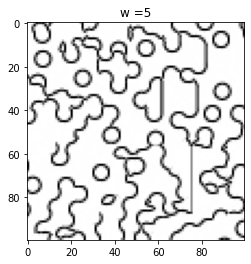

In [14]:
source = cv2.imread('rings.jpg')
w = 5
target = Synth_texture(source, w, [100, 100])

plt.imshow(target)
plt.title('w =' + str(w))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete


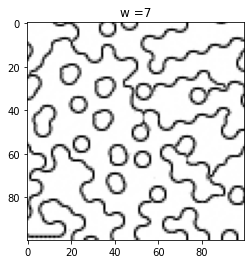

In [15]:
source = cv2.imread('rings.jpg')
w = 7
target = Synth_texture(source, w, [100, 100])

plt.imshow(target)
plt.title('w =' + str(w))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete


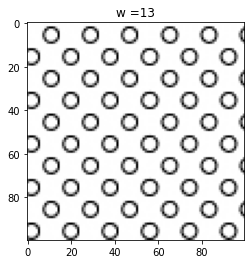

In [16]:
source = cv2.imread('rings.jpg')
w = 13
target = Synth_texture(source, w, [100, 100])

plt.imshow(target)
plt.title('w =' + str(w))
plt.show()